In [1]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.coordinates import Angle
import math
import aplpy#using aplpy to show FITS file
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

mpl.rcParams['figure.figsize'] = (9,9)#size of the figure
plt.rc('xtick', labelsize=14)#label size of x axis
plt.rc('ytick', labelsize=14)#label size of y axis
dashList = [(),(2,2,2,2,10,2),(5,2),(2,5),(4,10),(5,2,20,2)] #dash line style for plotting

RRL_dict = {
'H42a':85.688, 
'H41a':92.034,
'H40a':99.022,
'H39a':106.737,
'H36a':135.286,
'H35a':147.046,
'H34a':160.211,
'H30a':231.900,
'H29a':256.302,
}#RRL frequency

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }
vc = 299792.458#speed of light in km/s

obj = 'NGC3628'#galaxy name
z = 0.002812#galaxy redshift
line_name = line_namel = 'CO'#strongest line name for coding/line name for display
RRL_name = 'H30a'#RRL name for coding
RRL_namel = r'H30$\alpha$'#RRL name for display
line_rfreq = 230538/(1+z)#strongest line observed frequency in MHz
RRL_rfreq = RRL_dict[RRL_name]*1000/(1+z) #RRL observed frequency in MHz

bound_vel = 500#max limit of half of line width in km/s
beamsize_line = beamsize_RRL = 34.3537563395 #beam size of the image cubes of strongest line/RRL

/users/clau/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [ ]:
%cd data/

In [2]:
line_mom0_file = 'NGC_3628_CO.image.mom0.fits'#strongest line moment 0 map filename
RRL_mom0_file = 'NGC_3628_H30a.lineimage.w.mom0.fits'#RRL moment 0 map filename

line_data = fits.getdata(line_mom0_file)#read strongest line moment 0 map
box = np.array([200,220,320,320])#off-target box for noise measuring
region = np.array([100,100,270,170])#target box
c=  np.array([105,105,290,200])#larger target box

line_peak = line_data[region[1]:region[3],region[0]:region[2]].max()#peak of strongest line in target box
line_sigma = line_data[box[1]:box[3],box[0]:box[2]].std() #standard deviation of off-target box as noise(sigma)
psr = np.floor(line_peak/line_sigma)#peak-sigma ratio (max spatial theshold in terms of sigma)

steps_sigma_p =np.round(np.logspace(np.log10(3),np.log10(psr),num = 6,endpoint = False),1)#arrange the 6 spatial thesholds in logscale spacing, keep 1 decimal point, discarding the largest one
steps_sigma = np.concatenate((np.array([-4.5,-3.5,-2.5]),steps_sigma_p)) #including the largest spatial thesholds (created by smoothing with larger kernels)
#steps_sigma = steps_sigma_p
steps = steps_sigma_p*line_sigma #convert the spatial theshold in terms of sigma to real value (Jy)

line_mom0c2_file = 'NGC_3628_CO.image.mom0.conv2.fits'#mom0 map of larger spatial mask (kernel of 2 times of original beam)
line_sigma2 = fits.getdata(line_mom0c2_file)[box[1]:box[3],box[0]:box[2]].std() #get new sigma
#steps2 = 3*line_sigma2
steps25 = 3*line_sigma#set 3 sigma as the spatial theshold

line_mom0c3_file = 'NGC_3628_CO.image.mom0.conv3.fits'
line_sigma3 = fits.getdata(line_mom0c3_file)[box[1]:box[3],box[0]:box[2]].std()
#steps3 = 3*line_sigma3
steps35 = 3*line_sigma

line_mom0c4_file = 'NGC_3628_CO.image.mom0.conv4.fits'
line_sigma4 = fits.getdata(line_mom0c4_file)[box[1]:box[3],box[0]:box[2]].std()
#steps4 = 3*line_sigma3
steps45 = 3*line_sigma

steps_sigma

array([-4.5, -3.5, -2.5,  3. ,  5.2,  9.1, 15.9, 27.7, 48.2])

In [3]:
def strong_line(s_thres,v_thres,rebin = 0,plot=False,plotin = False,lshift=0,rshift=0):
#function for analyzing strongest line, inputing spatial threshold(in terms of sigma), velocity threshold (multiples of FWHM), bin width in velocity for rebin, plotting option, option for outputing plotting data,channel shift for left velocity boundary, that for right velocity boundary (if the auto search don't work properly)
    line_file = line_name + '_' + str(s_thres)+'.txt'#filename of strongest line
    line = np.loadtxt(line_file)#read the file
    line_freq = line[:,2]#getting the frequencies
    line_vel = vc*(line_rfreq-line_freq)/line_rfreq#convert the freq into velocity (setting the theoretical redshifted line freq as 0 vel)
    line_flux = line[:,4]#getting the flux
    area = line[0,1]#number of the unmasked pixels
    nbeam_line = round(area / beamsize_line,1)# masked area in terms of beam number in 1 d.p.
    
    ####################################rebining########################
    if rebin != 0:
        rebin_factor = int(rebin//np.abs(line_vel[1]-line_vel[0]))#convert the bin width in velocity into number of channels in each bin
        if rebin_factor ==0:#don't rebin if the number of chanels smaller than 1
            rebin_factor = 1
        
        line_vel_rebin = np.empty(0)#rebin the velocity
        for i in range(int(len(line_vel)//rebin_factor)):
            line_vel_rebin = np.append(line_vel_rebin,np.average(line_vel[rebin_factor*i:rebin_factor*(i+1)]))

        line_flux_rebin = np.empty(0)#rebin the flux
        for i in range(int(len(line_flux)//rebin_factor)):
            line_flux_rebin = np.append(line_flux_rebin,np.average(line_flux[rebin_factor*i:rebin_factor*(i+1)]))
        
        line_vel_old,line_flux_old = line_vel,line_flux #store the original velocity and flux
        line_vel,line_flux = line_vel_rebin,line_flux_rebin#use the new rebinned velocity and flux
        
    ####################################finding line peak########################
            
    line_flux_peak = max(line_flux) #get the peak of flux
    line_flux_peak_index = line_flux.argmax()#get the location of the peak in channel number

    ####################################finding FWHM and the location in the wider bins########################
    line_flux_dif_l = []
    lbound = line_flux_peak_index-int(bound_vel//np.abs(line_vel[1]-line_vel[0]))#set the max limit for searching the LHS of FWHM 
    for i in range(line_flux_peak_index-lshift,lbound,-1):
        line_flux_dif_l.append(line_flux[i]-line_flux_peak*0.5) #calculate the difference of flux and half of the peak (finding the closest point to the LHS of FWHM)
    line_flux_dif_l = np.array(line_flux_dif_l)
    line_index_left = line_flux_dif_l[line_flux_dif_l>0].argmin()  #located the point closest to the LHS of FWHM
    line_vel_left = line_vel[line_flux_peak_index-lshift:lbound:-1]#convert the index to velocity (converting the velocity list to the searching list itself)
    line_vel_left = line_vel_left[line_flux_dif_l>0]#"
    line_vel_left = line_vel_left[line_index_left]#"
    line_index_left = np.where(line_vel==line_vel_left)[0][0]#matching the old index to new index
    line_vel_left = line_vel[line_index_left]#located the LHS of FWHM

    line_flux_dif_r = []#same procedue for finding RHS of FWHM
    rbound = line_flux_peak_index+int(bound_vel//np.abs(line_vel[1]-line_vel[0]))
    for i in range(line_flux_peak_index+rshift,rbound):
        line_flux_dif_r.append(line_flux[i]-line_flux_peak*0.5)
    line_flux_dif_r = np.array(line_flux_dif_r)
    line_index_right = line_flux_dif_r[line_flux_dif_r>0].argmin() 
    line_vel_right = line_vel[line_flux_peak_index+rshift:rbound]
    line_vel_right = line_vel_right[line_flux_dif_r>0]
    line_vel_right = line_vel_right[line_index_right] 
    line_index_right = np.where(line_vel==line_vel_right)[0][0]
    line_vel_right = line_vel[line_index_right]
    
    W = np.abs(line_vel_right-line_vel_left)#get FWHM
    W_bin = W//np.abs(line_vel[1]-line_vel[0])#get channel numbers of FWHM
    if rebin >10 and W_bin < 4: #if velocity bin > 10 km/s and channel numbers of FWHM >4, lowering the velocity bin
        return strong_line(s_thres,v_thres,rebin = rebin-5,plot=plot,plotin=plotin)
    elif rebin <=10 and W_bin < 4: #if velocity bin<= 10 km/s and channel numbers of FWHM <4, don't reduce the velocity bin
        W_bin = 4#minimum number of channels for FWHM
    W = W_bin*np.abs(line_vel[1]-line_vel[0]) #get FWHM
    
    #########################finding the left/right integrating boundary for velocity thresholds################
    
    if rebin != 0:#restoring the velocity/flux list into the original ones(before rebin)
        line_vel_rebin,line_flux_rebin = line_vel,line_flux
        line_vel,line_flux = line_vel_old,line_flux_old
    
    W_bin = W//np.abs(line_vel[1]-line_vel[0])#channel number of FWHM in original bins
    
    line_vel_centre = (line_vel_left + line_vel_right)/2 #center of the width at half maximum 
    line_index_centre = abs(line_vel-line_vel_centre).argmin()#index of the center

    line_index_left = line_index_centre - math.ceil(W_bin/2*v_thres)# for different velocity threshold, apply the respective left integrating boundary
    line_index_left_full = line_index_centre - math.ceil(W_bin/2*4) #index away from the line peak (LHS,4FWHM)
    line_vel_left = line_vel[line_index_left]   #velocity of the left integrating boundary
    
    line_index_right = line_index_centre + math.ceil(W_bin/2*v_thres) #right part
    line_index_right_full = line_index_centre + math.ceil(W_bin/2*4)
    line_vel_right = line_vel[line_index_right]

    W = np.abs(line_vel_right-line_vel_left)  #FWHM in original bins
    
    ###################################measuring flux and uncertainty#############################

    line_total_flux = 0
    for i in range(line_index_left,line_index_right):
        line_total_flux += line_flux[i] * np.abs((line_vel[1]-line_vel[0])) #integrating the flux from left integrating boundary to right integrating boundary 
        
    #sigma_chan= np.std(sigma_clip(line_flux))
    #sigma_chan = np.std(sigma_clip(np.concatenate((line_flux[:line_index_left_full],line_flux[line_index_right_full:]))))
    sigma_chan = np.std(line_flux[:line_index_left_full]) #measuring the standard deviation of flux away from the line from the most left channel to the LHS of 4*FWHM
    sigma_line = sigma_chan * np.sqrt(line_index_right-line_index_left) #multiply that by sqrt of number of channels
    sigma_line = sigma_line * W/(line_index_right-line_index_left)#multiply that by the channel width in km/s

    SN_line = line_total_flux / sigma_line#signal to noise ratio 
    
    #####################################plotting the spectrum############################################
    if rebin != 0:
        line_vel,line_flux = line_vel_rebin,line_flux_rebin #use the rebinned velocity and flux in plotting
        
    if plot == True:
        plt.figure()
        plt.plot(line_vel,line_flux,lw=1)#plotting the spectrum
        plt.axvline(x=line_vel_left, color ='g')#indicate the left integrating velocity boundary
        plt.axvline(x=line_vel_right, color ='r')#indicate the right integrating velocity boundary
        plt.xlabel('Velocity (km/s)', fontdict=font)
        plt.ylabel(line_name+' flux density (Jy)', fontdict=font)
        plt.rc('font', size=15) 
        plt.show()
        #plt.close()
    #####################################outputing the parameters#############################

    if plotin ==True:
        return(W,line_vel,line_flux,line_vel_left,line_vel_right)
    else:
        return(W,line_total_flux,sigma_line,SN_line,line_index_left,line_index_right,nbeam_line,rebin,line_flux_peak)

In [4]:
def RRL(s_thres,W,plot = False,rebin = 0,line_index_left = 0,line_index_right=0,plotin = False):
#function for analyzing RRL/weak line, similar to that for strongest line, inputting the spatial threshold, plotting option, bin width in velocity for rebinning
    RRL_file = RRL_name +'_'+str(s_thres)+'.txt' 
    RRL = np.loadtxt(RRL_file)
    RRL_freq = RRL[:,2]
    RRL_vel = vc*(RRL_rfreq-RRL_freq)/RRL_rfreq
    RRL_flux = RRL[:,4]
    area = RRL[0,1]
    nbeam_RRL = round(area / beamsize_RRL,1)
    
    RRL_flux_peak = max(RRL_flux)
    
    RRL_index_left = (np.abs(RRL_vel-W/2)).argmin()#applying the same FWHM of stongest line to RRL/weak lines
    RRL_index_right = (np.abs(RRL_vel+W/2)).argmin()
    if RRL_index_left>RRL_index_right:
        RRL_index_right,RRL_index_left= RRL_index_left,RRL_index_right

    RRL_vel_left = RRL_vel[RRL_index_left]
    RRL_vel_right = RRL_vel[RRL_index_right]
        
    RRL_total_flux = 0
    for i in range(RRL_index_left,RRL_index_right):
        RRL_total_flux += RRL_flux[i] * np.abs((RRL_vel[1]-RRL_vel[0]))
    
    sigma_chan = np.std(sigma_clip(RRL_flux))
    #if (line_index_left is not 0) and (line_index_right is not 0):
    #    sigma_chan = np.std(sigma_clip(np.concatenate((RRL_flux[:line_index_left],RRL_flux[line_index_right:RRL_index_left],RRL_flux[RRL_index_right:]))))
    #else:
    #    sigma_chan = np.std(sigma_clip(np.concatenate((RRL_flux[:RRL_index_left],RRL_flux[RRL_index_right:]))))
    sigma_RRL = sigma_chan * np.sqrt(RRL_index_right-RRL_index_left)
    sigma_RRL = sigma_RRL * W/(RRL_index_right-RRL_index_left)

    SN_RRL = RRL_total_flux / sigma_RRL
    
    if rebin != 0:
        rebin_factor = int(rebin//np.abs(RRL_vel[1]-RRL_vel[0]))
        if rebin_factor ==0:
            rebin_factor = 1
        
        RRL_vel_rebin = np.empty(0)
        for i in range(int(len(RRL_vel)//rebin_factor)):
            RRL_vel_rebin = np.append(RRL_vel_rebin,np.average(RRL_vel[rebin_factor*i:rebin_factor*(i+1)]))

        RRL_flux_rebin = np.empty(0)
        for i in range(int(len(RRL_flux)//rebin_factor)):
            RRL_flux_rebin = np.append(RRL_flux_rebin,np.average(RRL_flux[rebin_factor*i:rebin_factor*(i+1)]))

        RRL_vel_left = RRL_vel_rebin[abs(RRL_vel_rebin-RRL_vel_left).argmin()]
        RRL_vel_right = RRL_vel_rebin[abs(RRL_vel_rebin-RRL_vel_right).argmin()]
        
    if plot == True:
        plt.figure()
        plt.plot(RRL_vel_rebin,RRL_flux_rebin,linewidth = 1)
        plt.axvline(x=RRL_vel_left, color ='g')
        plt.axvline(x=RRL_vel_right, color ='r')
        plt.xlabel('Velocity (km/s)', fontdict=font)
        plt.ylabel(RRL_namel + ' flux density (Jy)', fontdict=font)
        plt.rc('font', size=15) 
        plt.show()
        #plt.close()
        
    if plotin ==True:
        return(RRL_vel_rebin,RRL_flux_rebin,RRL_vel_left,RRL_vel_right)
    else:
        return(RRL_total_flux,sigma_RRL,SN_RRL,RRL_index_left,RRL_index_right,nbeam_RRL,RRL_flux_peak)


<IPython.core.display.Javascript object>


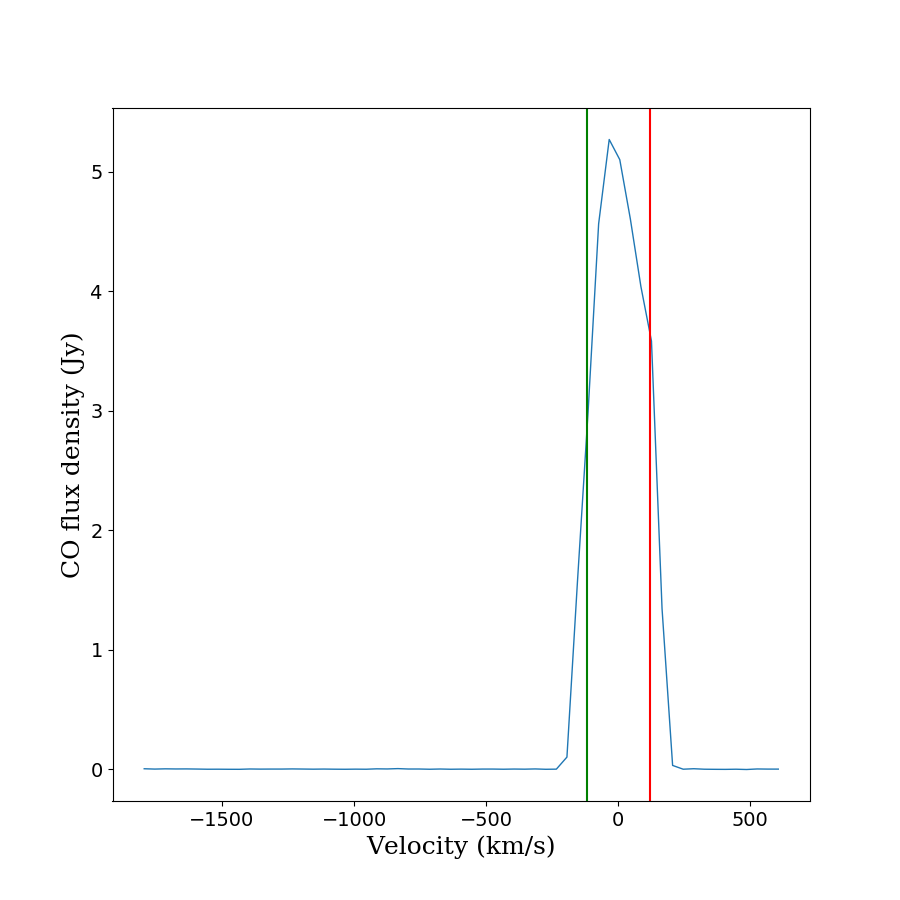

(239.9994308241532,
 1077.4210879828433,
 0.13201953838706146,
 8161.072983182281,
 169,
 193,
 82.6,
 45,
 5.269716000000001)

In [5]:
strong_line('3.0sigma',1,plot = True,rebin =50)

<IPython.core.display.Javascript object>


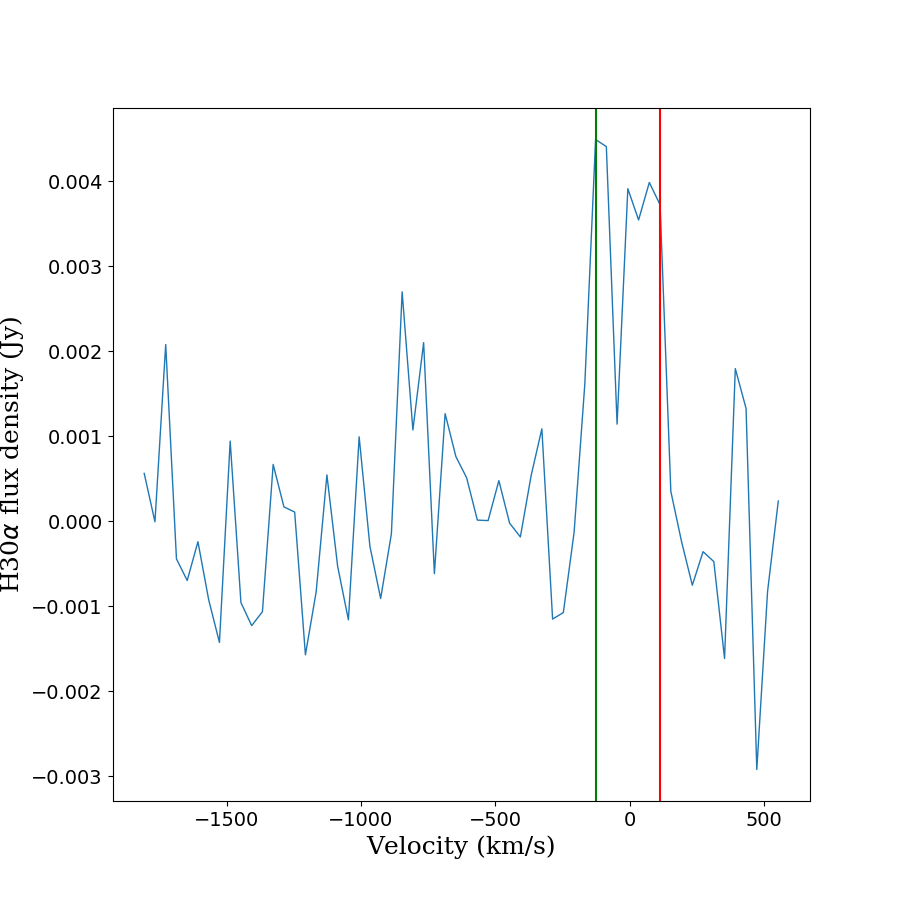

(0.8085699851402494,
 0.13302674946670828,
 6.078251091466418,
 170,
 194,
 82.6,
 0.01093904)

In [6]:
W,line_flux,sigma_line,SN_line,line_index_left,line_index_right,nbeam,rebin,line_peak= strong_line('3.0sigma',1,rebin = 50)
RRL('3.0sigma',W,plot = True,rebin = rebin)

In [8]:
rebin = rebin_o = 50 #rebin to 50 km/s
s_thres_array = steps_sigma#spatial thesholds
#s_thres_darray = np.linspace(0,1,num=7)
v_thres_array = [0.5,1,1.5,2,2.5,3] #velocity thesholds

#initate all the array for storing different values
line_flux = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
RRL_flux = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
sigma_line = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
sigma_RRL = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
SN_line = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
SN_RRL = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
RRL_line = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
W = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
line_peak = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
RRL_peak = np.empty([np.size(s_thres_array),np.size(v_thres_array)])
nbeam_line = np.empty(np.size(s_thres_array),dtype = int)
nbeam_RRL = np.empty(np.size(s_thres_array),dtype = int)

# Do the analysis for every spatial and velocity thesholds
for s in range(len(s_thres_array)):
    for w in range(len(v_thres_array)):
        s_thres = str(s_thres_array[s])+'sigma'
        W[s,w],line_flux[s,w],sigma_line[s,w],SN_line[s,w],line_index_left,line_index_right,nbeam_line[s],rebin,line_peak[s,w] = strong_line(s_thres,v_thres_array[w],rebin = rebin,plot = False)
        #print(W[s,w],line_flux[s,w],sigma_line[s,w],SN_line[s,w],line_index_left[w],line_index_right[w])
        RRL_flux[s,w], sigma_RRL[s,w], SN_RRL[s,w],RRL_index_left,RRL_index_right,nbeam_RRL[s],RRL_peak[s,w] = RRL(s_thres,W[s,w],rebin = rebin,plot = False)#using the same FWHM(W)
        #print(RRL_flux[s,w], sigma_RRL[s,w], SN_RRL[s,w])
        rebin = rebin_o

In [9]:
maskn = 3 #number of larger spatial masks by convoluting 
s_p = 3+maskn#chosen spatial threshold of highest S/N for strongest line
w_p = 2#chosen velocity threshold of highest S/N for strongest line
s_p2 = 4+maskn#chosen spatial threshold of highest S/N for RRL/weak line
w_p2 = 3#chosen velocity threshold of highest S/N for RRL/weak line

<IPython.core.display.Javascript object>


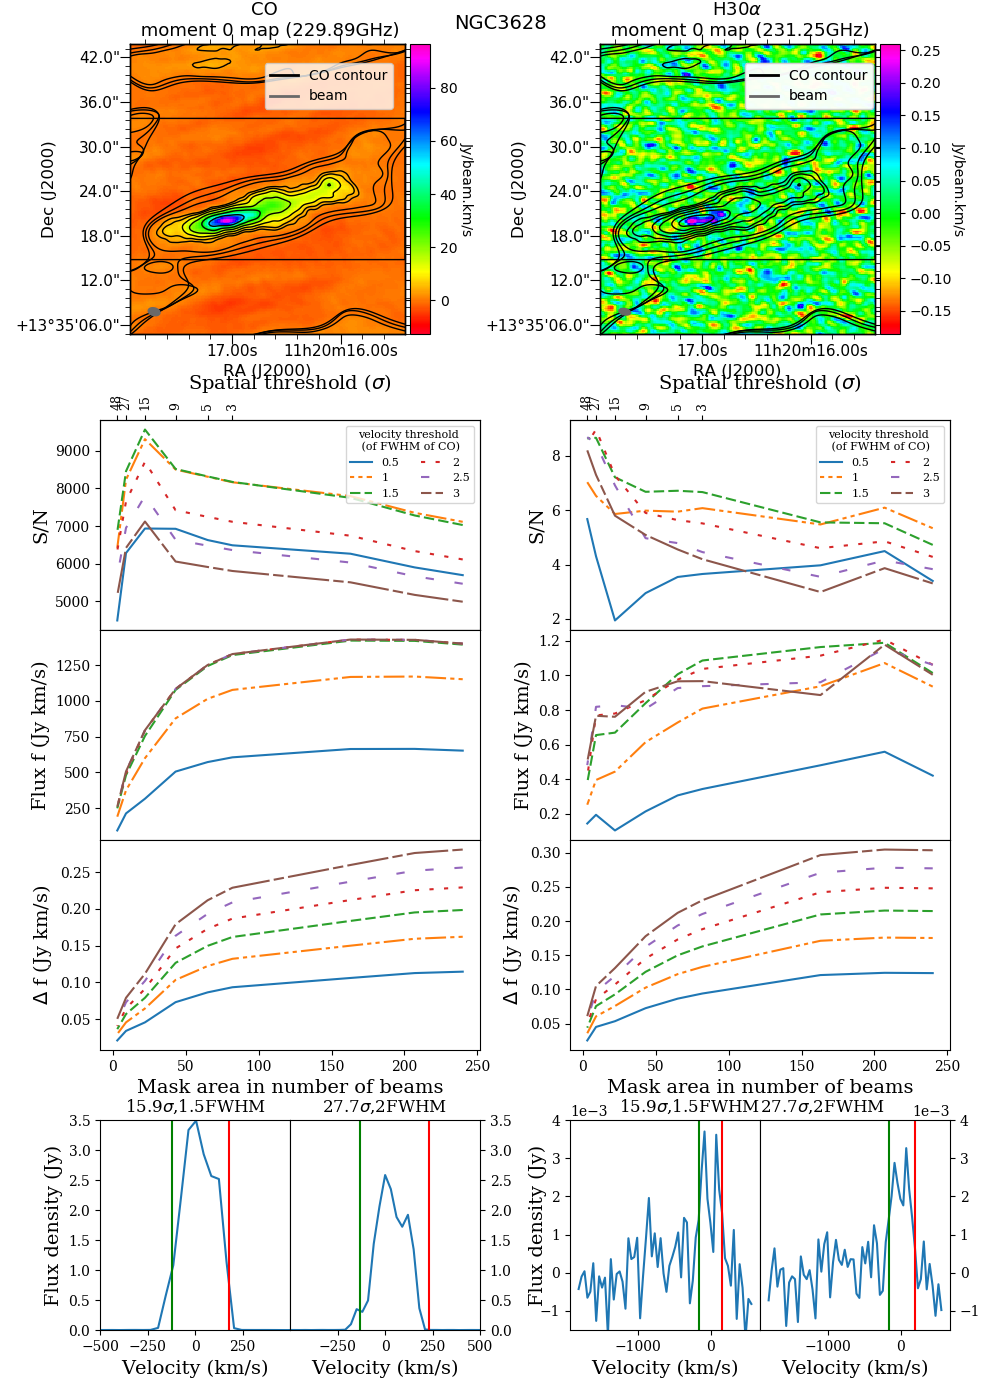

INFO: Auto-setting vmin to -1.261e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.638e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.859e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.598e-01 [aplpy.core]


(-0.0015, 0.004)

In [10]:
nbeam_line_p = nbeam_line[maskn:]#show only the spatial theshold without convolving
nbeam_RRL_p = nbeam_RRL[maskn:]#show only the spatial theshold without convolving
s_thes_array_p = np.int_(steps_sigma_p)

fig99 = plt.figure(99,figsize=(10,14))#initiate the figure
fig99.suptitle(obj, fontsize=14, y=0.99)#setup the overall title as the name of the galaxy
ax1 = aplpy.FITSFigure(line_mom0_file,figure = fig99,subplot = [0.13,0.64,0.3,0.45])#using aplpy to show the strongest line mom0 FITS file
ax1.set_title(line_namel+' \n moment 0 map ({:.5g}GHz)'.format(line_rfreq/1000),fontsize =13)#setup the name of the subplot
ax1.tick_labels.set_font(size=11)
ax1.axis_labels.set_font(size=12)
ax1.show_colorscale(cmap='gist_rainbow',pmax =99.99)# change the colormap
ax1.ticks.show()
ax1.ticks.set_color('black')
ax1.ticks.set_xspacing(Angle('0 0 1 hours').degree)#xticks spacings
ax1.axis_labels.set_ypad(-30)
plt.xlim(c[0],c[2])#zoom in to the extended region with some space on top and below to make the whole subplot be square
plt.ylim(c[1]-50,c[3]+50)
ax1.add_colorbar()
ax1.colorbar.set_font(size=10)
ax1.colorbar.set_axis_label_text('Jy/beam.km/s')
ax1.colorbar.set_axis_label_rotation(270)
ax1.colorbar.set_axis_label_pad(12)
ax1.colorbar.set_axis_label_font(size =10)
ax1.add_beam()
ax1.beam.set_edgecolor('dimgrey')
ax1.beam.set_facecolor('dimgrey')
ax1.beam.set_linewidth(2)
ax1.show_contour(line_mom0_file,levels = steps, colors = 'k',linewidths =1)#show contours
#ax1.show_contour(line_mom0c2_file,levels = steps2, colors = 'k',linewidths =1)
ax1.show_contour(line_mom0c2_file,levels = steps25, colors = 'k',linewidths =1)#show contour of bigger masks made by convolving
#ax1.show_contour(line_mom0c3_file,levels = steps3, colors = 'k',linewidths =1)
ax1.show_contour(line_mom0c3_file,levels = steps35, colors = 'k',linewidths =1)
ax1.show_contour(line_mom0c4_file,levels = steps45, colors = 'k',linewidths =1)
x_lbc, y_lbc = ax1.pixel2world(c[0],c[1]) #get the WCS coordinates of the 4 corners of extended region (only for this target)
x_urc, y_urc = ax1.pixel2world(c[2],c[3])
polygonc=np.array([[x_lbc,y_lbc],[x_urc,y_lbc],[x_urc,y_urc],[x_lbc,y_urc]]),
ax1.show_polygons(polygonc,edgecolor='k') #show the extended region (only for this target)

ax2 = aplpy.FITSFigure(RRL_mom0_file,figure = fig99,subplot = [0.6,0.64,0.3,0.45])
ax2.set_title(RRL_namel+' \n moment 0 map ({:.5g}GHz)'.format(RRL_rfreq/1000),fontsize =13)#using aplpy to show the RRL/weakline mom0 FITS file
ax2.tick_labels.set_font(size=11)
ax2.axis_labels.set_font(size=12)
ax2.show_colorscale(cmap='gist_rainbow',pmax =99.99)
ax2.ticks.show()
ax2.ticks.set_color('black')
ax2.ticks.set_xspacing(Angle('0 0 1 hours').degree)
ax2.axis_labels.set_ypad(-30)
plt.xlim(c[0],c[2])
plt.ylim(c[1]-50,c[3]+50)
ax2.add_colorbar()
ax2.colorbar.set_font(size=10)
ax2.colorbar.set_axis_label_text('Jy/beam.km/s')
ax2.colorbar.set_axis_label_rotation(270)
ax2.colorbar.set_axis_label_pad(10)
ax2.colorbar.set_axis_label_font(size =10)
ax2.add_beam()
ax2.beam.set_edgecolor('dimgrey')
ax2.beam.set_facecolor('dimgrey')
ax2.beam.set_linewidth =(2)
ax2.show_contour(line_mom0_file,levels = steps, colors = 'k',linewidths =1)
#ax2.show_contour(line_mom0c2_file,levels = steps2, colors = 'k',linewidths =1)
ax2.show_contour(line_mom0c2_file,levels = steps25, colors = 'k',linewidths =1)
#ax2.show_contour(line_mom0c3_file,levels = steps3, colors = 'k',linewidths =1)
ax2.show_contour(line_mom0c3_file,levels = steps35, colors = 'k',linewidths =1)
ax2.show_contour(line_mom0c4_file,levels = steps45, colors = 'k',linewidths =1)
ax2.show_polygons(polygonc,edgecolor='k')

###make the contour and beam legend###
hlist =[mlines.Line2D([],[],c='k',lw=2,label = line_namel+' contour'),mlines.Line2D([],[],c='dimgrey',lw=2,label = 'beam')]
legend1 = plt.legend(handles = hlist,fontsize=10,bbox_to_anchor=(0.4, 0.96),bbox_transform=plt.gcf().transFigure)
legend2 = plt.legend(handles = hlist,fontsize=10,bbox_to_anchor=(0.88, 0.96),bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax3 = fig99.add_axes([0.1,0.55,0.38,0.15])
for w in range(len(v_thres_array)):
    ax3.plot(nbeam_line, SN_line[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel('S/N', fontdict=font2)
lg3 = ax3.legend(title="velocity threshold \n (of FWHM of "+ line_name+")",fontsize=8,ncol=2)
lg3.get_title().set_fontsize(8)
ax3b = ax3.twiny()#add the top (second) x-axis
ax3b.set_xlim(ax3.get_xlim())
ax3b.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
ax3b.set_xticks(nbeam_line_p)#show the ticks at the respective spatial thresholds
ax3b.set_xticklabels(s_thes_array_p,fontsize =9,rotation = 90)

ax4 = fig99.add_axes([0.57,0.55,0.38,0.15])
for w in range(len(v_thres_array)):
    ax4.plot(nbeam_RRL, SN_RRL[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax4.get_xaxis().set_visible(False)
ax4.set_ylabel('S/N', fontdict=font2)
lg4 = ax4.legend( title="velocity threshold \n (of FWHM of "+ line_name+")",fontsize=8,ncol=2)
lg4.get_title().set_fontsize(8)
ax4b = ax4.twiny()
ax4b.set_xlim(ax4.get_xlim())
ax4b.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
ax4b.set_xticks(nbeam_RRL_p)
ax4b.set_xticklabels(s_thes_array_p,fontsize =9,rotation = 90)
    
ax5 = fig99.add_axes([0.1,0.4,0.38,0.15])
for w in range(len(v_thres_array)):
    ax5.plot(nbeam_line, line_flux[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax5.get_xaxis().set_visible(False)
ax5.set_ylabel('Flux f (Jy km/s)', fontdict=font2)


ax6 = fig99.add_axes([0.57,0.4,0.38,0.15])
for w in range(len(v_thres_array)):
    ax6.plot(nbeam_RRL, RRL_flux[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax6.get_xaxis().set_visible(False)
ax6.set_ylabel('Flux f (Jy km/s)', fontdict=font2)

ax7 = fig99.add_axes([0.1,0.25,0.38,0.15])
for w in range(len(v_thres_array)):
    ax7.plot(nbeam_line, sigma_line[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax7.set_xlabel('Mask area in number of beams', fontdict=font2)
ax7.set_ylabel(r'$\Delta$ f (Jy km/s)', fontdict=font2)

ax8 = fig99.add_axes([0.57,0.25,0.38,0.15])
for w in range(len(v_thres_array)):
    ax8.plot(nbeam_RRL, sigma_RRL[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax8.set_xlabel('Mask area in number of beams', fontdict=font2)
ax8.set_ylabel(r'$\Delta$ f (Jy km/s)', fontdict=font2)
    
s_thres_p = str(s_thres_array[s_p])+'sigma'#the chosen spatial theshold best for strongest line extraction
s_thres_pl = str(s_thres_array[s_p])+r'$\sigma$'#the display version of the chosen spatial theshold

####getting the spectrum ###########
W_p,line_vel_p,line_flux_p,line_vel_left,line_vel_right = strong_line(s_thres_p,v_thres_array[w_p],rebin = 50,plotin = True)
RRL_vel_p,RRL_flux_p,RRL_vel_left,RRL_vel_right = RRL(s_thres_p,W_p,rebin = 50,plotin = True)

s_thres_p2 = str(s_thres_array[s_p2])+'sigma'#the chosen spatial theshold best for RRL/weak line extraction
s_thres_pl2 = str(s_thres_array[s_p2])+r'$\sigma$'#diplay version

####getting the spectrum ###########
W_p2,line_vel_p2,line_flux_p2,line_vel_left2,line_vel_right2 = strong_line(s_thres_p2,v_thres_array[w_p2],rebin = 50,plotin = True)
RRL_vel_p2,RRL_flux_p2,RRL_vel_left2,RRL_vel_right2 = RRL(s_thres_p2,W_p2,rebin = 50,plotin = True)

#####plotting the spectrum of stongest line using spatial theshold best for strongest line extraction
ax9 = fig99.add_axes([0.1,0.05,0.19,0.15])
ax9.plot(line_vel_p,line_flux_p)
ax9.set_xlabel('Velocity (km/s)', fontdict=font2)
ax9.set_ylabel('Flux density (Jy)', fontdict=font2)
ax9.axvline(x=line_vel_left, color ='g')
ax9.axvline(x=line_vel_right, color ='r')
ax9.set_title(s_thres_pl+','+str(v_thres_array[w_p])+'FWHM',fontsize = 12)
ax9.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax9.set_xlim(-500,500)
ax9.set_xticks(ax9.get_xticks()[:-1])
ax9.set_ylim(0,3.5)

#####plotting the spectrum of stongest line using spatial theshold best for RRL/weak line extraction
ax9b = fig99.add_axes([0.29,0.05,0.19,0.15])
ax9b.plot(line_vel_p2,line_flux_p2)
ax9b.set_xlabel('Velocity (km/s)', fontdict=font2)
ax9b.axvline(x=line_vel_left2, color ='g')
ax9b.axvline(x=line_vel_right2, color ='r')
ax9b.set_title(s_thres_pl2+','+str(v_thres_array[w_p2])+'FWHM',fontsize = 12)
ax9b.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax9b.yaxis.tick_right()
ax9b.set_xlim(-500,500)
ax9b.set_xticks(ax9b.get_xticks()[1:])
ax9b.set_ylim(0,3.5)

#####plotting the spectrum of RRL/weak line using spatial theshold best for strongest line extraction
ax10 = fig99.add_axes([0.57,0.05,0.19,0.15])
ax10.plot(RRL_vel_p,RRL_flux_p)
ax10.set_xlabel('Velocity (km/s)', fontdict=font2)
ax10.set_ylabel('Flux density (Jy)', fontdict=font2,labelpad =-5)
ax10.axvline(x=RRL_vel_left, color ='g')
ax10.axvline(x=RRL_vel_right, color ='r')
ax10.set_title(s_thres_pl+','+str(v_thres_array[w_p])+'FWHM',fontsize = 12,loc='right')
ax10.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax10.set_ylim(-0.0015,0.004)

#####plotting the spectrum of RRL/weak line using spatial theshold best for RRL/weak line extraction
ax10b = fig99.add_axes([0.76,0.05,0.19,0.15])
ax10b.plot(RRL_vel_p2,RRL_flux_p2)
ax10b.set_xlabel('Velocity (km/s)', fontdict=font2)
#ax10b.set_ylabel(RRL_namel+' flux density (Jy)', fontdict=font2)
ax10b.axvline(x=RRL_vel_left2, color ='g')
ax10b.axvline(x=RRL_vel_right2, color ='r')
ax10b.set_title(s_thres_pl2+','+str(v_thres_array[w_p2])+'FWHM',fontsize = 12,loc='left')
ax10b.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax10b.yaxis.tick_right()
ax10b.set_ylim(-0.0015,0.004)    

In [8]:
fig99.savefig('{}_{}_{}.pdf'.format(obj,line_name,RRL_name))

In [11]:
###############displaying the measured parameters
s,w = s_p,w_p
print(obj)
print(s_thres_array[s],v_thres_array[w])
print(line_namel)
print('{:g}'.format(float('{:.6g}'.format(line_flux[s,w]))))#integrated flux of strongest line
print('{:g}'.format(float('{:.6g}'.format(sigma_line[s,w]))))#flux uncertainty of strongest line
print('{:g}'.format(float('{:.3g}'.format(SN_line[s,w]))))#signal-to-noise of strongest line
print(nbeam_line[s])
print('{:g}'.format(float('{:.3g}'.format(line_peak[s,w]))))#peak of strongest line
print('{:g}'.format(float('{:.6g}'.format(line_peak[s,w]*W[s,1]))))#peak of strongest line times FWHM
print(RRL_namel)
print('{:g}'.format(float('{:.3g}'.format(RRL_flux[s,w]))))#integrated flux of RRL/weak line
print('{:g}'.format(float('{:.2g}'.format(sigma_RRL[s,w]))))#flux uncertainty of RRL/weak line
print('{:g}'.format(float('{:.3g}'.format(SN_RRL[s,w]))))#signal-to-noise of RRL/weak line
print(nbeam_RRL[s])
print('{:g}'.format(float('{:.3g}'.format(RRL_peak[s,w]))))#peak of RRL/weak line
print('{:g}'.format(float('{:.6g}'.format(RRL_peak[s,w]*W[s,1]))))#peak of RRL/weak line times FWHM
print('{:g}'.format(float('{:.3g}'.format(W[s,1])))) #FWHM

s,w = s_p2,w_p2
print(obj)
print(s_thres_array[s],v_thres_array[w])
print(line_namel)
print('{:g}'.format(float('{:.6g}'.format(line_flux[s,w]))))
print('{:g}'.format(float('{:.2g}'.format(sigma_line[s,w]))))
print('{:g}'.format(float('{:.3g}'.format(SN_line[s,w]))))
print(nbeam_line[s])
print('{:g}'.format(float('{:.3g}'.format(line_peak[s,w]))))
print('{:g}'.format(float('{:.6g}'.format(line_peak[s,w]*W[s,1]))))
print(RRL_namel)
print('{:g}'.format(float('{:.4g}'.format(RRL_flux[s,w]))))
print('{:g}'.format(float('{:.2g}'.format(sigma_RRL[s,w]))))
print('{:g}'.format(float('{:.3g}'.format(SN_RRL[s,w]))))
print(nbeam_RRL[s])
print('{:g}'.format(float('{:.5g}'.format(RRL_peak[s,w]))))
print('{:g}'.format(float('{:.6g}'.format(RRL_peak[s,w]*W[s,1]))))
print('{:g}'.format(float('{:.3g}'.format(W[s,1]))))

NGC3628
15.9 1.5
CO
755.083
0.0789937
9560
22
3.49
697.709
H30$\alpha$
0.67
0.093
7.21
22
0.00612
1.22322
200
NGC3628
27.7 2
CO
493.793
0.065
7650
9
2.58
464.888
H30$\alpha$
0.7693
0.086
8.97
9
0.0059299
1.06737
180


In [12]:
s_p_e = 2#chosen spatial theshold for extended emission
w_p_e = 2#chosen velocity theshold for extended emission

<IPython.core.display.Javascript object>


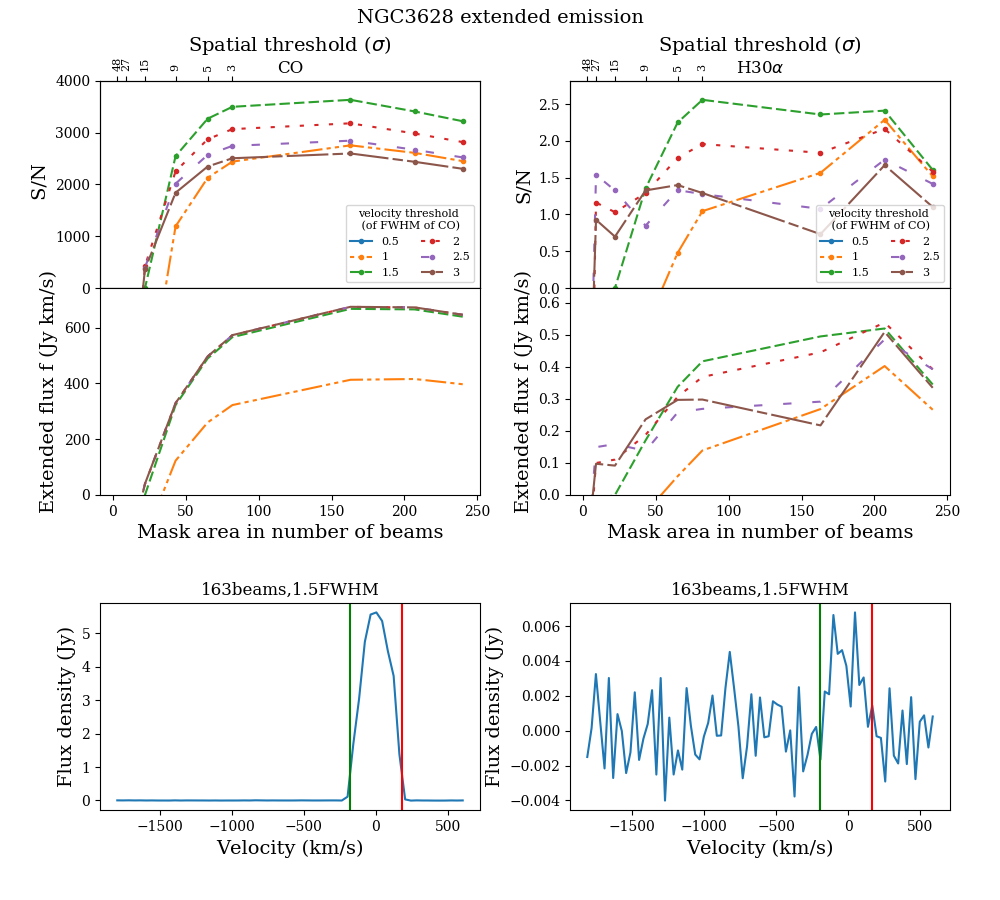

Text(0.5,1,'163beams,1.5FWHM')

In [13]:
line_flux_e = line_flux - line_flux[s_p,w_p]#substract core emission(the flux extracted by using the thresholds just selected) from the total emission in the extended region
RRL_flux_e = RRL_flux - RRL_flux[s_p,w_p]
SN_line_e = line_flux_e/sigma_line
SN_RRL_e = RRL_flux_e/sigma_RRL

nbeam_line_p = nbeam_line[maskn:]#showing only the spatial thesholds created by original mom0 maps
nbeam_RRL_p = nbeam_RRL[maskn:]
s_thes_array_p = np.int_(steps_sigma_p)

fig200 = plt.figure(200,figsize=(10,9))
fig200.suptitle(obj +' extended emission', fontsize=14, y=0.99)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax3 = fig200.add_axes([0.1,0.68,0.38,0.23])
for w in range(len(v_thres_array)):
    ax3.plot(nbeam_line, SN_line_e[:,w],'.',label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax3.set_title(line_namel,fontsize =12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel(' S/N', fontdict=font2)
ax3.set_ylim(0,np.max(SN_line_e)*1.1)
lg3 = ax3.legend( title="velocity threshold \n (of FWHM of "+ line_name+")",fontsize=8,ncol=2)
lg3.get_title().set_fontsize(8)
ax3b = ax3.twiny()
ax3b.set_xlim(ax3.get_xlim())
ax3b.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
ax3b.set_xticks(nbeam_line_p)
ax3b.set_xticklabels(s_thes_array_p,fontsize=8,rotation=90)
    

ax4 = fig200.add_axes([0.57,0.68,0.38,0.23])
for w in range(len(v_thres_array)):
    ax4.plot(nbeam_RRL, SN_RRL_e[:,w],'.',label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax4.set_title(RRL_namel,fontsize =12)
ax4.get_xaxis().set_visible(False)
ax4.set_ylabel('S/N', fontdict=font2)
ax4.set_ylim(0,np.max(SN_RRL_e)*1.1)
lg4 = ax4.legend( title="velocity threshold \n (of FWHM of "+ line_name+")",fontsize=8,ncol=2)
lg4.get_title().set_fontsize(8)
ax4b = ax4.twiny()
ax4b.set_xlim(ax4.get_xlim())
ax4b.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
ax4b.set_xticks(nbeam_RRL_p)
ax4b.set_xticklabels(s_thes_array_p,fontsize=8,rotation=90)
    
    
ax5 = fig200.add_axes([0.1,0.45,0.38,0.23])
for w in range(len(v_thres_array)):
    ax5.plot(nbeam_line, line_flux_e[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax5.set_xlabel('Mask area in number of beams', fontdict=font2)
ax5.set_ylabel('Extended flux f (Jy km/s)', fontdict=font2)
ax5.set_ylim(0,np.max(line_flux_e)*1.1)

    
ax6 = fig200.add_axes([0.57,0.45,0.38,0.23])
for w in range(len(v_thres_array)):
    ax6.plot(nbeam_RRL, RRL_flux_e[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax6.set_xlabel('Mask area in number of beams', fontdict=font2)
ax6.set_ylabel('Extended flux f (Jy km/s)', fontdict=font2)
ax6.set_ylim(0,np.max(RRL_flux_e)*1.2)
    
s_thres_p = str(s_thres_array[s_p_e])+'sigma'

W_p,line_vel_p,line_flux_p,line_vel_left,line_vel_right = strong_line(s_thres_p,v_thres_array[w_p_e],rebin = 40,plotin = True)
RRL_vel_p,RRL_flux_p,RRL_vel_left,RRL_vel_right = RRL(s_thres_p,W_p,rebin = 40,plotin = True)

ax9 = fig200.add_axes([0.1,0.1,0.38,0.23])
ax9.plot(line_vel_p,line_flux_p)
ax9.set_xlabel('Velocity (km/s)', fontdict=font2)
ax9.set_ylabel('Flux density (Jy)', fontdict=font2)
ax9.axvline(x=line_vel_left, color ='g')
ax9.axvline(x=line_vel_right, color ='r')
ax9.set_title(str(nbeam_line[s_p_e])+'beams,'+str(v_thres_array[w_p_e])+'FWHM',fontsize = 12)

ax10 = fig200.add_axes([0.57,0.1,0.38,0.23])
ax10.plot(RRL_vel_p,RRL_flux_p)
ax10.set_xlabel('Velocity (km/s)', fontdict=font2)
ax10.set_ylabel('Flux density (Jy)', fontdict=font2)
ax10.axvline(x=RRL_vel_left, color ='g')
ax10.axvline(x=RRL_vel_right, color ='r')
ax10.set_title(str(nbeam_RRL[s_p_e])+'beams,'+str(v_thres_array[w_p_e])+'FWHM',fontsize = 12)

In [11]:
fig200.savefig('{}_{}_{}_extended.pdf'.format(obj,line_name,RRL_name))

In [14]:
se,we = s_p_e,w_p_e#simplfing the symbols
s,w = s_p,w_p
print(obj)
print('extended emission')
print(line_namel)
print('{:g}'.format(float('{:.6g}'.format(line_flux[se,we]-line_flux[s,w]))))#extended emission
print('{:g}'.format(float('{:.3g}'.format(sigma_line[se,we]))))#flux uncertainty
print('{:g}'.format(float('{:.3g}'.format((line_flux[se,we]-line_flux[s,w])/sigma_line[se,we]))))#signal-to-noise
print(nbeam_line[se])
print()
print('{:g}'.format(float('{:.3g}'.format(W[se,1]))))
print()
print(RRL_namel)
print('{:g}'.format(float('{:.6g}'.format(RRL_flux[se,we]-RRL_flux[s,w]))))#for undetected RRL,no substration is needed
print('{:g}'.format(float('{:.3g}'.format(sigma_RRL[se,we]))))
print('{:g}'.format(float('{:.3g}'.format((RRL_flux[se,we]-RRL_flux[s,w])/sigma_RRL[se,we]))))#"
print(nbeam_RRL[se])


NGC3628
extended emission
CO
667.171
0.184
3630
163

240

H30$\alpha$
0.494691
0.21
2.36
163


In [15]:
s_p_e2 = 3#the respective extended emission extraction thesholds for best core emission thesholds for RRL/weak line extraction
w_p_e2 = 2

<IPython.core.display.Javascript object>


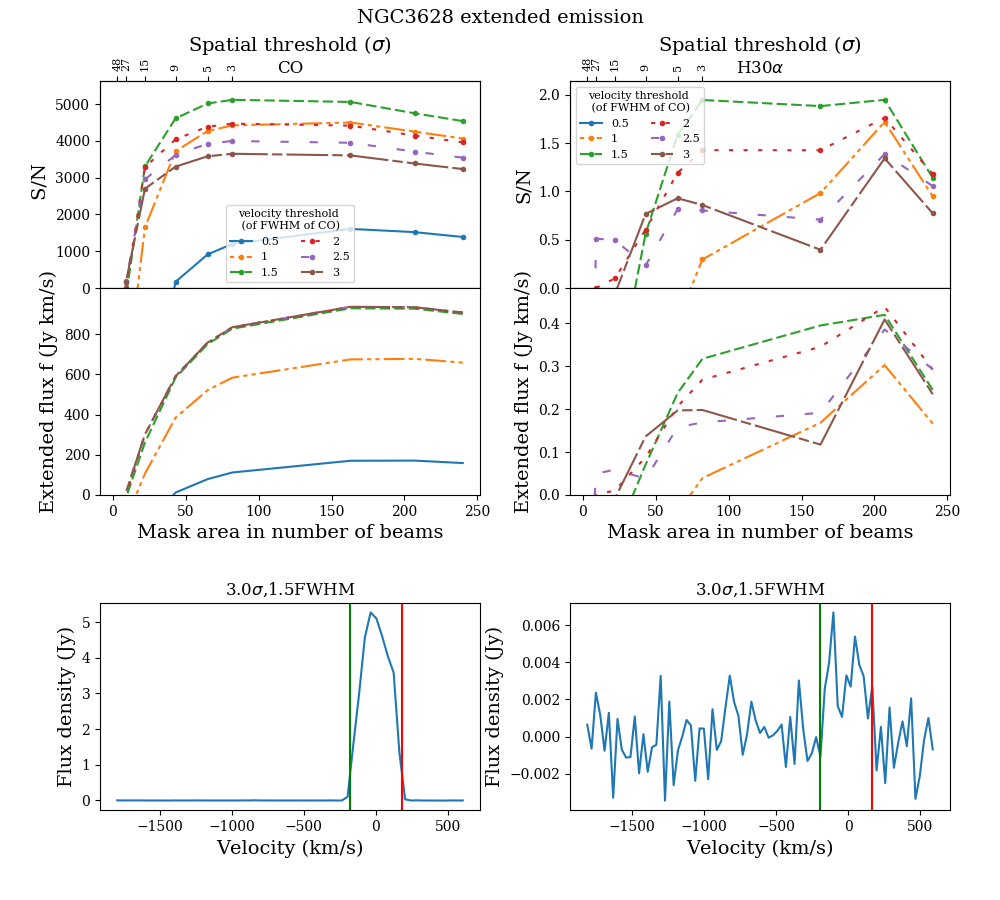

Text(0.5,1,'3.0$\\sigma$,1.5FWHM')

In [16]:
line_flux_e2 = line_flux - line_flux[s_p2,w_p2]
RRL_flux_e2 = RRL_flux - RRL_flux[s_p2,w_p2]
SN_line_e2 = line_flux_e2/sigma_line
SN_RRL_e2 = RRL_flux_e2/sigma_RRL


nbeam_line_p = nbeam_line[maskn:]
nbeam_RRL_p = nbeam_RRL[maskn:]
s_thes_array_p = np.int_(steps_sigma_p)

fig201 = plt.figure(201,figsize=(10,9))
fig201.suptitle(obj +' extended emission', fontsize=14, y=0.99)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax3 = fig201.add_axes([0.1,0.68,0.38,0.23])
for w in range(len(v_thres_array)):
    ax3.plot(nbeam_line, SN_line_e2[:,w],'.',label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax3.set_title(line_namel,fontsize =12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel(' S/N', fontdict=font2)
ax3.set_ylim(0,np.max(SN_line_e2)*1.1)
lg3 = ax3.legend( title="velocity threshold \n (of FWHM of "+ line_name+")",fontsize=8,ncol=2)
lg3.get_title().set_fontsize(8)
ax3b = ax3.twiny()
ax3b.set_xlim(ax3.get_xlim())
ax3b.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
ax3b.set_xticks(nbeam_line_p)
ax3b.set_xticklabels(s_thes_array_p,fontsize=8,rotation=90)
    

ax4 = fig201.add_axes([0.57,0.68,0.38,0.23])
for w in range(len(v_thres_array)):
    ax4.plot(nbeam_RRL, SN_RRL_e2[:,w],'.',label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax4.set_title(RRL_namel,fontsize =12)
ax4.get_xaxis().set_visible(False)
ax4.set_ylabel('S/N', fontdict=font2)
ax4.set_ylim(0,np.max(SN_RRL_e2)*1.1)
lg4 = ax4.legend( title="velocity threshold \n (of FWHM of "+ line_name+")",fontsize=8,ncol=2)
lg4.get_title().set_fontsize(8)
ax4b = ax4.twiny()
ax4b.set_xlim(ax4.get_xlim())
ax4b.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
ax4b.set_xticks(nbeam_RRL_p)
ax4b.set_xticklabels(s_thes_array_p,fontsize=8,rotation=90)
    
    
ax5 = fig201.add_axes([0.1,0.45,0.38,0.23])
for w in range(len(v_thres_array)):
    ax5.plot(nbeam_line, line_flux_e2[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax5.set_xlabel('Mask area in number of beams', fontdict=font2)
ax5.set_ylabel('Extended flux f (Jy km/s)', fontdict=font2)
ax5.set_ylim(0,np.max(line_flux_e2)*1.1)
ax5.set_yticks(ax5.get_yticks()[:-2])

    
ax6 = fig201.add_axes([0.57,0.45,0.38,0.23])
for w in range(len(v_thres_array)):
    ax6.plot(nbeam_RRL, RRL_flux_e2[:,w],label = v_thres_array[w], linestyle='--', dashes=dashList[w])
ax6.set_xlabel('Mask area in number of beams', fontdict=font2)
ax6.set_ylabel('Extended flux f (Jy km/s)', fontdict=font2)
ax6.set_ylim(0,np.max(RRL_flux_e2)*1.1)


s_thres_p = str(s_thres_array[s_p_e2])+'sigma'
s_thres_pl = str(s_thres_array[s_p_e2])+r'$\sigma$'

W_p,line_vel_p,line_flux_p,line_vel_left,line_vel_right = strong_line(s_thres_p,v_thres_array[w_p_e2],rebin = 40,plotin = True)
RRL_vel_p,RRL_flux_p,RRL_vel_left,RRL_vel_right = RRL(s_thres_p,W_p,rebin = 40,plotin = True)

ax9 = fig201.add_axes([0.1,0.1,0.38,0.23])
ax9.plot(line_vel_p,line_flux_p)
ax9.set_xlabel('Velocity (km/s)', fontdict=font2)
ax9.set_ylabel('Flux density (Jy)', fontdict=font2)
ax9.axvline(x=line_vel_left, color ='g')
ax9.axvline(x=line_vel_right, color ='r')
ax9.set_title(s_thres_pl+','+str(v_thres_array[w_p_e2])+'FWHM',fontsize = 12)

ax10 = fig201.add_axes([0.57,0.1,0.38,0.23])
ax10.plot(RRL_vel_p,RRL_flux_p)
ax10.set_xlabel('Velocity (km/s)', fontdict=font2)
ax10.set_ylabel('Flux density (Jy)', fontdict=font2)
ax10.axvline(x=RRL_vel_left, color ='g')
ax10.axvline(x=RRL_vel_right, color ='r')
ax10.set_title(s_thres_pl+','+str(v_thres_array[w_p_e2])+'FWHM',fontsize = 12)

In [14]:
fig201.savefig('{}_{}_{}_extended2.pdf'.format(obj,line_name,RRL_name))

In [17]:
se,we = s_p_e2,w_p_e2
s,w = s_p,w_p
print(obj)
print('extended emission')
print(line_namel)
print('{:g}'.format(float('{:.5g}'.format(line_flux[se,we]-line_flux[s,w]))))
print('{:g}'.format(float('{:.3g}'.format(sigma_line[se,we]))))
print('{:g}'.format(float('{:.3g}'.format((line_flux[se,we]-line_flux[s,w])/sigma_line[se,we]))))
print(nbeam_line[se])
print()
print('{:g}'.format(float('{:.3g}'.format(W[se,1]))))
print()
print(RRL_namel)
print('{:g}'.format(float('{:.5g}'.format(RRL_flux[se,we]-RRL_flux[s,w]))))
print('{:g}'.format(float('{:.3g}'.format(sigma_RRL[se,we]))))
print('{:g}'.format(float('{:.3g}'.format((RRL_flux[se,we]-RRL_flux[s,w])/sigma_RRL[se,we]))))
print(nbeam_RRL[se])

NGC3628
extended emission
CO
565.87
0.162
3500
82

240

H30$\alpha$
0.41702
0.163
2.56
82


In [18]:
x_lb, y_lb = ax1.pixel2world(c[0],c[1]-50)
x_ur, y_ur = ax1.pixel2world(c[2],c[3]+50)

<IPython.core.display.Javascript object>


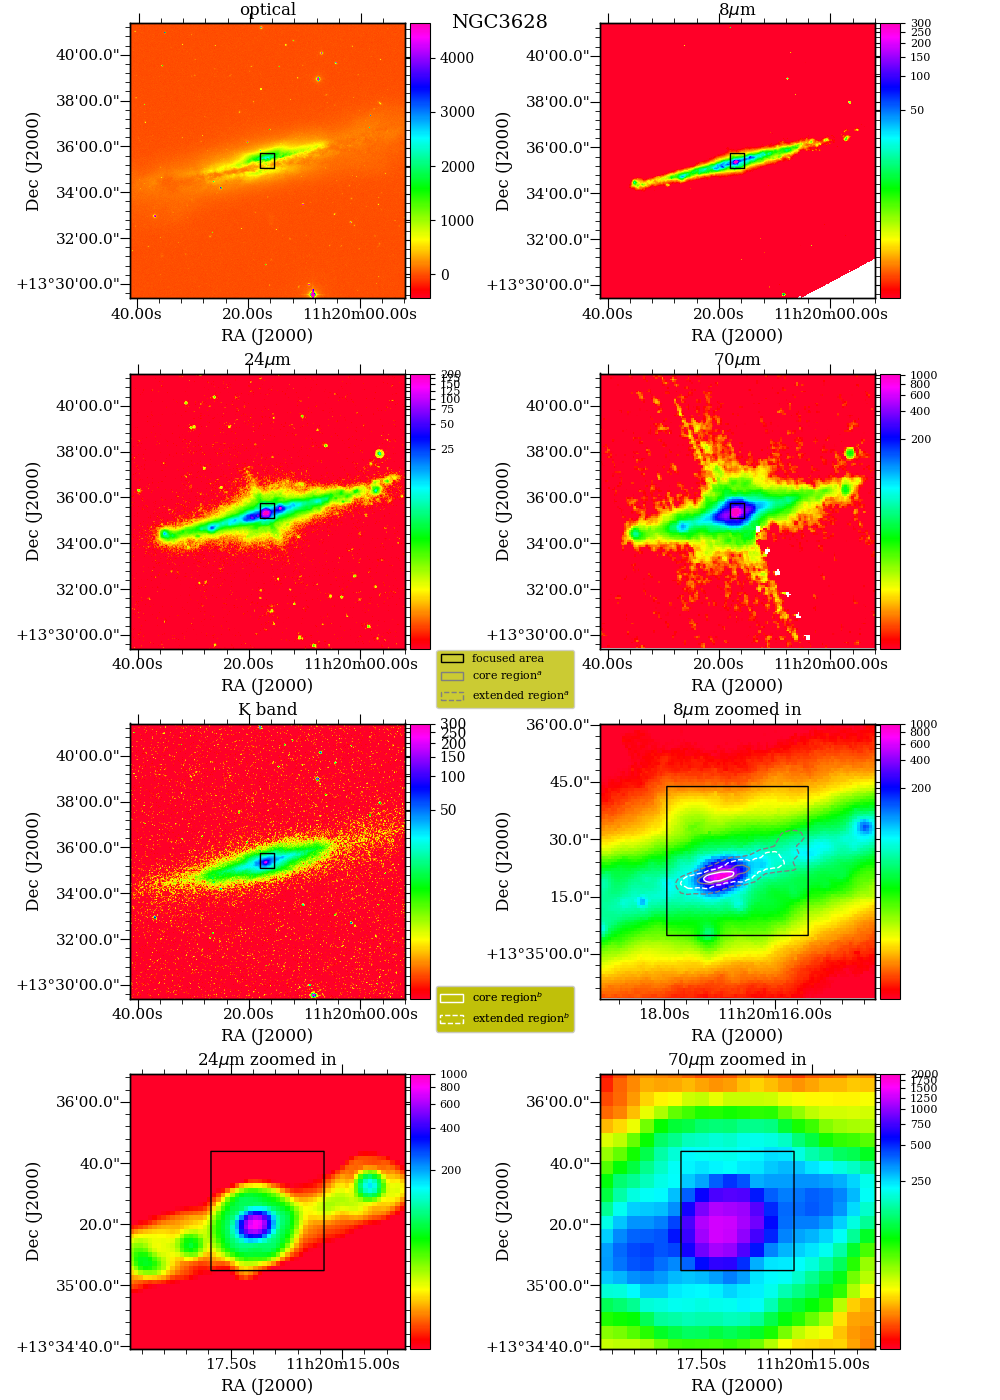

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -4.493e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.634e+03 [aplpy.core]


/users/clau/.local/lib/python3.6/site-packages/aplpy/wcs_util.py:515: UserWarning: Pixels are not square, using an average pixel scale
  warnings.warn("Pixels are not square, using an average pixel scale")
/users/clau/.local/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting vmax to  1.043e+03 [aplpy.core]


In [19]:
xs = Angle('0 0 20 hours').degree
zw = zh = 0.2
fig300 = plt.figure(300,figsize=(10,14))
fig300.suptitle(obj, fontsize=14, y=0.99)
fig_opt = aplpy.FITSFigure("image/NGC_3628_KPNO0.9m_R_c2014.fits",figure = fig300,subplot = [0.13,0.66,0.3,0.45])
fig_opt.set_title('optical',fontsize =12)
fig_opt.show_colorscale(cmap='gist_rainbow',pmax =99.95)
fig_opt.tick_labels.set_font(size=11)
fig_opt.axis_labels.set_font(size=12)
fig_opt.ticks.show()
fig_opt.ticks.set_color('black')
fig_opt.ticks.set_xspacing(xs)
fig_opt.axis_labels.set_ypad(-20)
fig_opt.add_colorbar()
fig_opt.colorbar.set_font(size=10)
polygon=np.array([[x_lb,y_lb],[x_ur,y_lb],[x_ur,y_ur],[x_lb,y_ur]]),
fig_opt.show_polygons(polygon,edgecolor='k')
fig_opt.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw, height=zh)

fig_8um = aplpy.FITSFigure("image/NGC_3628_I_IRAC_8.0_d2009.fits",figure = fig300,subplot = [0.6,0.66,0.3,0.45])
fig_8um.set_title(r'8$\mu$m',fontsize =12)
fig_8um.show_colorscale(cmap='gist_rainbow',stretch='log',vmin=1,vmax =300)
fig_8um.tick_labels.set_font(size=11)
fig_8um.axis_labels.set_font(size=12)
fig_8um.ticks.show()
fig_8um.ticks.set_color('black')
fig_8um.ticks.set_xspacing(xs)
fig_8um.axis_labels.set_ypad(-20)
fig_8um.add_colorbar()
fig_8um.colorbar.set_font(size=8)
fig_8um.show_polygons(polygon,edgecolor='k')
fig_8um.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw, height=zh)

fig_24um = aplpy.FITSFigure("image/NGC_3628_I_MIPS24_d2009.fits",figure = fig300,subplot = [0.13,0.41,0.3,0.45])
fig_24um.show_colorscale(cmap='gist_rainbow',stretch='log',vmin=0.1,vmax = 200)
fig_24um.set_title(r'24$\mu$m',fontsize =12)
fig_24um.tick_labels.set_font(size=11)
fig_24um.axis_labels.set_font(size=12)
fig_24um.ticks.show()
fig_24um.ticks.set_color('black')
fig_24um.ticks.set_xspacing(xs)
fig_24um.axis_labels.set_ypad(-20)
fig_24um.add_colorbar()
fig_24um.colorbar.set_font(size=8)
fig_24um.show_polygons(polygon,edgecolor='k')
fig_24um.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw, height=zh)

fig_70um = aplpy.FITSFigure("image/NGC_3628_I_MIPS70_d2009.fits",dimensions=[0, 1],figure = fig300,subplot = [0.6,0.41,0.3,0.45])
fig_70um.show_colorscale(cmap='gist_rainbow',stretch='log',vmin = 1,pmax=99.99)
fig_70um.set_title(r'70$\mu$m',fontsize =12)
fig_70um.tick_labels.set_font(size=11)
fig_70um.axis_labels.set_font(size=12)
fig_70um.ticks.show()
fig_70um.ticks.set_color('black')
fig_70um.ticks.set_xspacing(xs)
fig_70um.axis_labels.set_ypad(-20)
fig_70um.add_colorbar()
fig_70um.colorbar.set_font(size=8)
fig_70um.show_polygons(polygon,edgecolor='k')
fig_70um.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw, height=zh)

fig_K = aplpy.FITSFigure("image/2MASS_NGC_3628_K.fits",figure = fig300,subplot = [0.13,0.16,0.3,0.45])
fig_K.show_colorscale(cmap='gist_rainbow',stretch='log',vmin=1,vmax =300)
fig_K.set_title('K band',fontsize =12)
fig_K.tick_labels.set_font(size=11)
fig_K.axis_labels.set_font(size=12)
fig_K.ticks.show()
fig_K.ticks.set_color('black')
fig_K.ticks.set_xspacing(xs)
fig_K.axis_labels.set_ypad(-20)
fig_K.add_colorbar()
fig_K.colorbar.set_font(size=10)
fig_K.show_polygons(polygon,edgecolor='k')
fig_K.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw, height=zh)

fig_8umb = aplpy.FITSFigure("image/NGC_3628_I_IRAC_8.0_d2009.fits",figure = fig300,subplot = [0.6,0.16,0.3,0.45])
fig_8umb.set_title(r'8$\mu$m zoomed in',fontsize =12)
fig_8umb.show_colorscale(cmap='gist_rainbow',stretch='log',vmin=1,vmax = 1000)
fig_8umb.tick_labels.set_font(size=11)
fig_8umb.axis_labels.set_font(size=12)
fig_8umb.ticks.show()
fig_8umb.ticks.set_color('black')
fig_8umb.ticks.set_xspacing(xs/10)
fig_8umb.axis_labels.set_ypad(-20)
fig_8umb.add_colorbar()
fig_8umb.colorbar.set_font(size=8)
fig_8umb.show_polygons(polygon,edgecolor='k')
fig_8umb.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw/10, height=zh/10)
fig_8umb.show_regions('image/core.reg')
fig_8umb.show_regions('image/core_2.reg')
fig_8umb.show_regions('image/extended.reg')
fig_8umb.show_regions('image/extended_2.reg')

fig_24umb = aplpy.FITSFigure("image/NGC_3628_I_MIPS24_d2009.fits",figure = fig300,subplot = [0.13,-0.09,0.3,0.45])
fig_24umb.show_colorscale(cmap='gist_rainbow',stretch='log',vmin=10,vmax = 1000)
fig_24umb.set_title(r'24$\mu$m zoomed in',fontsize =12)
fig_24umb.tick_labels.set_font(size=11)
fig_24umb.axis_labels.set_font(size=12)
fig_24umb.ticks.show()
fig_24umb.ticks.set_color('black')
fig_24umb.ticks.set_xspacing(xs/8)
fig_24umb.axis_labels.set_ypad(-20)
fig_24umb.add_colorbar()
fig_24umb.colorbar.set_font(size=8)
fig_24umb.show_polygons(polygon,edgecolor='k')
fig_24umb.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw/8, height=zh/8)

fig_70umb = aplpy.FITSFigure("image/NGC_3628_I_MIPS70_d2009.fits",dimensions=[0, 1],figure = fig300,subplot = [0.6,-0.09,0.3,0.45])
fig_70umb.show_colorscale(cmap='gist_rainbow',stretch='log',vmin = 10,vmax=2000)
fig_70umb.set_title(r'70$\mu$m zoomed in',fontsize =12)
fig_70umb.tick_labels.set_font(size=11)
fig_70umb.axis_labels.set_font(size=12)
fig_70umb.ticks.show()
fig_70umb.ticks.set_color('black')
fig_70umb.ticks.set_xspacing(xs/8)
fig_70umb.axis_labels.set_ypad(-20)
fig_70umb.add_colorbar()
fig_70umb.colorbar.set_font(size=8)
fig_70umb.show_polygons(polygon,edgecolor='k')
fig_70umb.recenter((x_lb+x_ur)/2, (y_lb+y_ur)/2, width=zw/8, height=zh/8)

hlist =[mpatches.Patch(facecolor='None',edgecolor = 'k', label='focused area'),
        mpatches.Patch(facecolor='None',edgecolor = 'grey', linestyle = '-', label=r'core region$^a$'),
        mpatches.Patch(facecolor='None',edgecolor = 'grey', linestyle = '--', label=r'extended region$^a$')]
hlist2 =[mpatches.Patch(facecolor='None',edgecolor = 'w', linestyle = '-', label=r'core region$^b$'),
         mpatches.Patch(facecolor='None',edgecolor = 'w', linestyle = '--', label=r'extended region$^b$')]

legend1 = plt.legend(handles = hlist,fontsize=8,bbox_to_anchor=(0.58, 0.54),bbox_transform=plt.gcf().transFigure)
legend2 = plt.legend(handles = hlist2,fontsize=8,bbox_to_anchor=(0.58, 0.30),bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
frame1 = legend1.get_frame()
frame1.set_facecolor('y')
frame2 = legend2.get_frame()
frame2.set_facecolor('y')

In [18]:
fig300.savefig('{}_IR.pdf'.format(obj))

/users/clau/.local/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


<IPython.core.display.Javascript object>


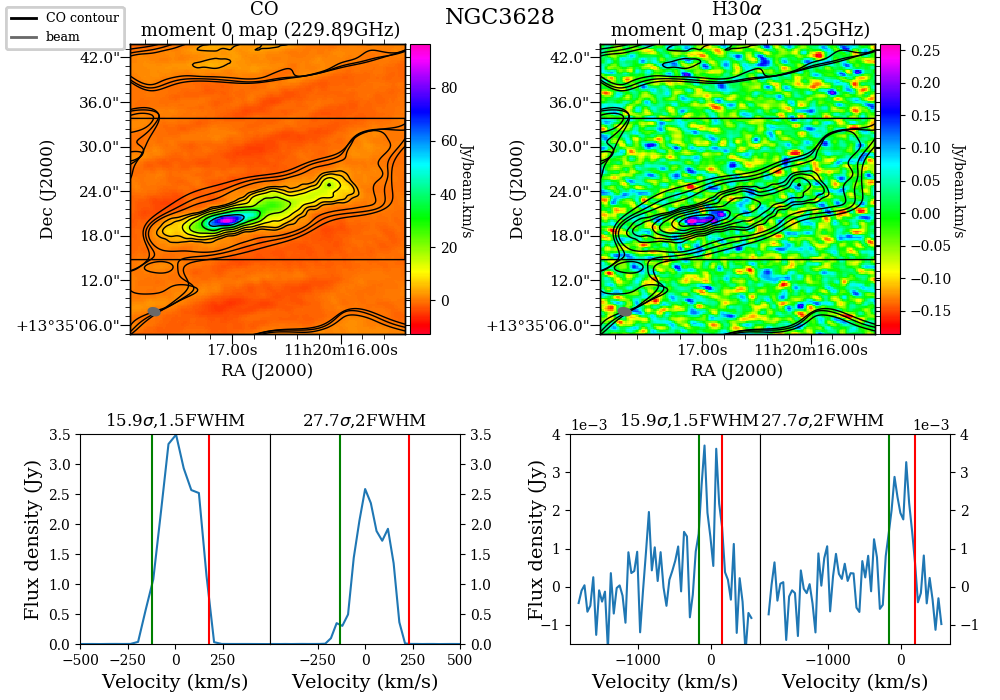

INFO: Auto-setting vmin to -1.261e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.638e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.859e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.598e-01 [aplpy.core]


(-0.0015, 0.004)

In [20]:
###shorter diagram for presentation only

nbeam_line_p = nbeam_line[maskn:]
nbeam_RRL_p = nbeam_RRL[maskn:]
s_thres_array_p = np.int_(steps_sigma_p)

fig401 = plt.figure(401,figsize=(10,7))
fig401.suptitle(obj, fontsize=16, y=0.99)
ax1 = aplpy.FITSFigure(line_mom0_file,figure = fig401,subplot = [0.13,0.28,0.3,0.9])
ax1.set_title(line_namel+' \n moment 0 map ({:.5g}GHz)'.format(line_rfreq/1000),fontsize =13)
ax1.tick_labels.set_font(size=11)
ax1.axis_labels.set_font(size=12)
ax1.show_colorscale(cmap='gist_rainbow',pmax =99.99)
ax1.ticks.show()
ax1.ticks.set_color('black')
ax1.ticks.set_xspacing(Angle('0 0 1 hours').degree)
ax1.axis_labels.set_ypad(-30)
plt.xlim(c[0],c[2])
plt.ylim(c[1]-50,c[3]+50)
ax1.add_colorbar()
ax1.colorbar.set_font(size=10)
ax1.colorbar.set_axis_label_text('Jy/beam.km/s')
ax1.colorbar.set_axis_label_rotation(270)
ax1.colorbar.set_axis_label_pad(12)
ax1.colorbar.set_axis_label_font(size =10)
ax1.add_beam()
ax1.beam.set_edgecolor('dimgrey')
ax1.beam.set_facecolor('dimgrey')
ax1.beam.set_linewidth(2)
ax1.show_contour(line_mom0_file,levels = steps, colors = 'k',linewidths =1)
#ax1.show_contour(line_mom0c2_file,levels = steps2, colors = 'k',linewidths =1)
ax1.show_contour(line_mom0c2_file,levels = steps25, colors = 'k',linewidths =1)
#ax1.show_contour(line_mom0c3_file,levels = steps3, colors = 'k',linewidths =1)
ax1.show_contour(line_mom0c3_file,levels = steps35, colors = 'k',linewidths =1)
ax1.show_contour(line_mom0c4_file,levels = steps45, colors = 'k',linewidths =1)
x_lbc, y_lbc = ax1.pixel2world(c[0],c[1])
x_urc, y_urc = ax1.pixel2world(c[2],c[3])
polygonc=np.array([[x_lbc,y_lbc],[x_urc,y_lbc],[x_urc,y_urc],[x_lbc,y_urc]]),
ax1.show_polygons(polygonc,edgecolor='k')

ax2 = aplpy.FITSFigure(RRL_mom0_file,figure = fig401,subplot = [0.6,0.28,0.3,0.9])
ax2.set_title(RRL_namel+' \n moment 0 map ({:.5g}GHz)'.format(RRL_rfreq/1000),fontsize =13)
ax2.tick_labels.set_font(size=11)
ax2.axis_labels.set_font(size=12)
ax2.show_colorscale(cmap='gist_rainbow',pmax =99.99)
ax2.ticks.show()
ax2.ticks.set_color('black')
ax2.ticks.set_xspacing(Angle('0 0 1 hours').degree)
ax2.axis_labels.set_ypad(-30)
plt.xlim(c[0],c[2])
plt.ylim(c[1]-50,c[3]+50)
ax2.add_colorbar()
ax2.colorbar.set_font(size=10)
ax2.colorbar.set_axis_label_text('Jy/beam.km/s')
ax2.colorbar.set_axis_label_rotation(270)
ax2.colorbar.set_axis_label_pad(10)
ax2.colorbar.set_axis_label_font(size =10)
ax2.add_beam()
ax2.beam.set_edgecolor('dimgrey')
ax2.beam.set_facecolor('dimgrey')
ax2.beam.set_linewidth(2)
ax2.show_contour(line_mom0_file,levels = steps, colors = 'k',linewidths =1)
#ax2.show_contour(line_mom0c2_file,levels = steps2, colors = 'k',linewidths =1)
ax2.show_contour(line_mom0c2_file,levels = steps25, colors = 'k',linewidths =1)
#ax2.show_contour(line_mom0c3_file,levels = steps3, colors = 'k',linewidths =1)
ax2.show_contour(line_mom0c3_file,levels = steps35, colors = 'k',linewidths =1)
ax2.show_contour(line_mom0c4_file,levels = steps45, colors = 'k',linewidths =1)
ax2.show_polygons(polygonc,edgecolor='k')

hlist =[mlines.Line2D([],[],c='k',lw=2,label = line_namel+' contour'),mlines.Line2D([],[],c='dimgrey',lw=2,label = 'beam')]
legend1 = plt.legend(handles = hlist,fontsize=9,bbox_to_anchor=(0.13, 0.999),bbox_transform=plt.gcf().transFigure)
legend1.get_frame().set_linewidth(2)
#legend2 = plt.legend(handles = hlist,fontsize=10,bbox_to_anchor=(0.88, 0.96),bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(legend1)
    
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

s_thres_p = str(s_thres_array[s_p])+'sigma'
s_thres_pl = str(s_thres_array[s_p])+r'$\sigma$'


W_p,line_vel_p,line_flux_p,line_vel_left,line_vel_right = strong_line(s_thres_p,v_thres_array[w_p],rebin = 50,plotin = True)
RRL_vel_p,RRL_flux_p,RRL_vel_left,RRL_vel_right = RRL(s_thres_p,W_p,rebin = 50,plotin = True)

s_thres_p2 = str(s_thres_array[s_p2])+'sigma'
s_thres_pl2 = str(s_thres_array[s_p2])+r'$\sigma$'

W_p2,line_vel_p2,line_flux_p2,line_vel_left2,line_vel_right2 = strong_line(s_thres_p2,v_thres_array[w_p2],rebin = 50,plotin = True)
RRL_vel_p2,RRL_flux_p2,RRL_vel_left2,RRL_vel_right2 = RRL(s_thres_p2,W_p2,rebin = 50,plotin = True)

ax9 = fig401.add_axes([0.08,0.08,0.19,0.3])
ax9.plot(line_vel_p,line_flux_p)
ax9.set_xlabel('Velocity (km/s)', fontdict=font2)
ax9.set_ylabel('Flux density (Jy)', fontdict=font2)
ax9.axvline(x=line_vel_left, color ='g')
ax9.axvline(x=line_vel_right, color ='r')
ax9.set_title(s_thres_pl+','+str(v_thres_array[w_p])+'FWHM',fontsize = 12)
ax9.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax9.set_xlim(-500,500)
ax9.set_xticks(ax9.get_xticks()[:-1])
ax9.set_ylim(0,3.5)

ax9b = fig401.add_axes([0.27,0.08,0.19,0.3])
ax9b.plot(line_vel_p2,line_flux_p2)
ax9b.set_xlabel('Velocity (km/s)', fontdict=font2)
ax9b.axvline(x=line_vel_left2, color ='g')
ax9b.axvline(x=line_vel_right2, color ='r')
ax9b.set_title(s_thres_pl2+','+str(v_thres_array[w_p2])+'FWHM',fontsize = 12)
ax9b.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax9b.yaxis.tick_right()
ax9b.set_xlim(-500,500)
ax9b.set_xticks(ax9b.get_xticks()[1:])
ax9b.set_ylim(0,3.5)

ax10 = fig401.add_axes([0.57,0.08,0.19,0.3])
ax10.plot(RRL_vel_p,RRL_flux_p)
ax10.set_xlabel('Velocity (km/s)', fontdict=font2)
ax10.set_ylabel('Flux density (Jy)', fontdict=font2,labelpad =-5)
ax10.axvline(x=RRL_vel_left, color ='g')
ax10.axvline(x=RRL_vel_right, color ='r')
ax10.set_title(s_thres_pl+','+str(v_thres_array[w_p])+'FWHM',fontsize = 12,loc='right')
ax10.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax10.set_ylim(-0.0015,0.004)

ax10b = fig401.add_axes([0.76,0.08,0.19,0.3])
ax10b.plot(RRL_vel_p2,RRL_flux_p2)
ax10b.set_xlabel('Velocity (km/s)', fontdict=font2)
#ax10b.set_ylabel(RRL_namel+' flux density (Jy)', fontdict=font2)
ax10b.axvline(x=RRL_vel_left2, color ='g')
ax10b.axvline(x=RRL_vel_right2, color ='r')
ax10b.set_title(s_thres_pl2+','+str(v_thres_array[w_p2])+'FWHM',fontsize = 12,loc='left')
ax10b.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax10b.yaxis.tick_right()
ax10b.set_ylim(-0.0015,0.004)
    
#ax9 = fig99.add_axes([0.1,0.05,0.38,0.15])
#ax9.plot(s_thres_array, W[:,2])
#ax9.set_xlabel(r'Spatial threshold ($\sigma$)', fontdict=font2)
#ax9.set_xticks(s_thres_array)
#ax9.set_ylabel('FWHM', fontdict=font2)

<IPython.core.display.Javascript object>


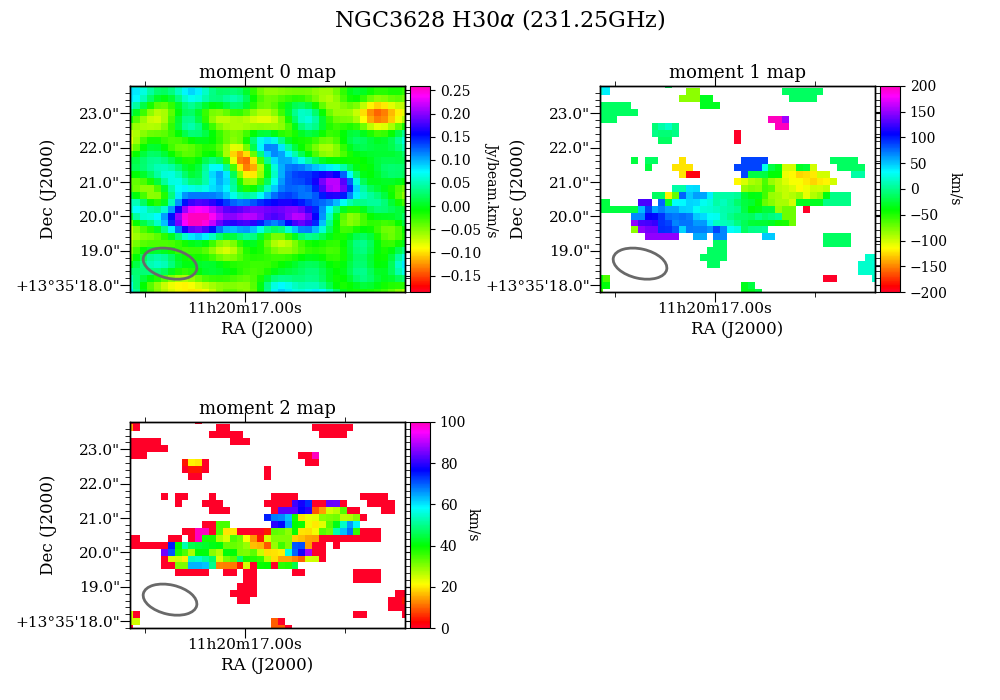

INFO:astropy:Auto-setting vmin to -1.859e-01
INFO:astropy:Auto-setting vmax to  2.598e-01


INFO: Auto-setting vmin to -1.859e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.598e-01 [aplpy.core]


/users/clau/.local/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


In [42]:
RRL_mom1_file = 'NGC_3628_H30a.lineimage.mom1.3s5s.fits'
RRL_mom2_file = 'NGC_3628_H30a.lineimage.mom2.3s5s.fits'
d = [157,120,197,150] #detailed core region
fig410 = plt.figure(410,figsize=(10,7))
fig410.suptitle('{} {} ({:.5g}GHz)'.format(obj,RRL_namel,RRL_rfreq/1000), fontsize=16, y=0.99)
ax1 = aplpy.FITSFigure(RRL_mom0_file,figure = fig410,subplot = [0.13,0.28,0.3,0.9])
ax1.set_title('moment 0 map',fontsize =13)
ax1.tick_labels.set_font(size=11)
ax1.axis_labels.set_font(size=12)
ax1.show_colorscale(cmap='gist_rainbow',pmax =99.99)
ax1.ticks.show()
ax1.ticks.set_color('black')
ax1.ticks.set_xspacing(Angle('0 0 1 hours').degree)
ax1.axis_labels.set_ypad(-30)
plt.xlim(d[0],d[2])
plt.ylim(d[1],d[3])
ax1.add_colorbar()
ax1.colorbar.set_font(size=10)
ax1.colorbar.set_axis_label_text('Jy/beam.km/s')
ax1.colorbar.set_axis_label_rotation(270)
ax1.colorbar.set_axis_label_pad(12)
ax1.colorbar.set_axis_label_font(size =10)
ax1.add_beam()
ax1.beam.set_edgecolor('dimgrey')
ax1.beam.set_facecolor('None')
ax1.beam.set_linewidth(2)


ax2 = aplpy.FITSFigure(RRL_mom1_file,figure = fig410,subplot = [0.6,0.28,0.3,0.9])
ax2.set_title('moment 1 map',fontsize =13)
ax2.tick_labels.set_font(size=11)
ax2.axis_labels.set_font(size=12)
ax2.show_colorscale(cmap='gist_rainbow',vmin=-200,vmax=200)
ax2.ticks.show()
ax2.ticks.set_color('black')
ax2.ticks.set_xspacing(Angle('0 0 1 hours').degree)
ax2.axis_labels.set_ypad(-30)
plt.xlim(d[0],d[2])
plt.ylim(d[1],d[3])
ax2.add_colorbar()
ax2.colorbar.set_font(size=10)
ax2.colorbar.set_axis_label_text('km/s')
ax2.colorbar.set_axis_label_rotation(270)
ax2.colorbar.set_axis_label_pad(10)
ax2.colorbar.set_axis_label_font(size =10)
ax2.add_beam()
ax2.beam.set_edgecolor('dimgrey')
ax2.beam.set_facecolor('None')
ax2.beam.set_linewidth(2)

ax3 = aplpy.FITSFigure(RRL_mom2_file,figure = fig410,subplot = [0.13,-0.20,0.3,0.9])
ax3.set_title('moment 2 map',fontsize =13)
ax3.tick_labels.set_font(size=11)
ax3.axis_labels.set_font(size=12)
ax3.show_colorscale(cmap='gist_rainbow',vmin=0,vmax=100)
ax3.ticks.show()
ax3.ticks.set_color('black')
ax3.ticks.set_xspacing(Angle('0 0 1 hours').degree)
ax3.axis_labels.set_ypad(-30)
plt.xlim(d[0],d[2])
plt.ylim(d[1],d[3])
ax3.add_colorbar()
ax3.colorbar.set_font(size=10)
ax3.colorbar.set_axis_label_text('km/s')
ax3.colorbar.set_axis_label_rotation(270)
ax3.colorbar.set_axis_label_pad(10)
ax3.colorbar.set_axis_label_font(size =10)
ax3.add_beam()
ax3.beam.set_edgecolor('dimgrey')
ax3.beam.set_facecolor('None')
ax3.beam.set_linewidth(2)


ax10 = fig401.add_axes([0.57,0.08,0.19,0.3])
ax10.plot(RRL_vel_p,RRL_flux_p)
ax10.set_xlabel('Velocity (km/s)', fontdict=font2)
ax10.set_ylabel('Flux density (Jy)', fontdict=font2,labelpad =-5)
ax10.axvline(x=RRL_vel_left, color ='g')
ax10.axvline(x=RRL_vel_right, color ='r')
ax10.set_title(s_thres_pl+','+str(v_thres_array[w_p])+'FWHM',fontsize = 12,loc='right')
ax10.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax10.set_ylim(-0.0015,0.004)

ax10b = fig401.add_axes([0.76,0.08,0.19,0.3])
ax10b.plot(RRL_vel_p2,RRL_flux_p2)
ax10b.set_xlabel('Velocity (km/s)', fontdict=font2)
#ax10b.set_ylabel(RRL_namel+' flux density (Jy)', fontdict=font2)
ax10b.axvline(x=RRL_vel_left2, color ='g')
ax10b.axvline(x=RRL_vel_right2, color ='r')
ax10b.set_title(s_thres_pl2+','+str(v_thres_array[w_p2])+'FWHM',fontsize = 12,loc='left')
ax10b.ticklabel_format(axis='y', style='sci',scilimits=(-2,2))
ax10b.yaxis.tick_right()
ax10b.set_ylim(-0.0015,0.004)